In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from scipy.stats import chi2_contingency , kstest, mannwhitneyu, ttest_ind
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import math
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from mlxtend.classifier import StackingClassifier
from skopt import BayesSearchCV
from skopt import gp_minimize
import plotly.graph_objects as go
from skopt.space import Categorical, Integer, Real
import random
random.seed(42)
%matplotlib inline

In [2]:
# Import data
diabetes = pd.read_csv(r"C:\Users\karuj\Downloads\archive (34)\diabetes.csv")

In [3]:
# Look at the formatting of the data
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Check the data stats
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# Find the shape of the data
(r, c) = diabetes.shape
(r,c)

(768, 9)

In [6]:
diabetes.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [7]:
def remove_outliers(df, threshold):
    dropped_rows = pd.DataFrame()  # DataFrame to store dropped rows

    # Iterate through each numeric column
    for column in df.select_dtypes(include=np.number):
        col_mean = df[column].mean()
        col_std = df[column].std()

        # Define the upper and lower bounds for outliers
        lower_bound = col_mean - threshold * col_std
        upper_bound = col_mean + threshold * col_std

        # Identify outliers and store the dropped rows
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        dropped_rows = pd.concat([dropped_rows, outliers])

    # Remove outliers from the DataFrame
    df_cleaned = df[~df.index.isin(dropped_rows.index)]

    return df_cleaned, dropped_rows


diabetes, dropped_rows = remove_outliers(diabetes, 3)
print("Shape of cleaned DataFrame:", diabetes.shape)
print("Dropped rows:")
print(dropped_rows)

Shape of cleaned DataFrame: (688, 9)
Dropped rows:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   
75             1        0             48             20        0  24.7   
..           ...      ...            ...            ...      ...   ...   
123            5      132             80              0        0  26.8   
453            2      119              0              0        0  19.6   
459            9      134             74             33       60  25.9   
666            4      145             82             18        0  32.5   
684            5      136             82              0        0   0.0   

     DiabetesPedigreeFunction  Age  Outcome  
88            

In [8]:
diabetes_copy = diabetes.copy()
diabetes_copy

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [9]:
diabetes_copy.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df = diabetes["Outcome"].value_counts()
# Get the count of rows where outcome is 0
count_outcome_0 = df.get(0, 0)  # Ensure to handle the case where 0 might not exist in the index

# Get the indices of rows where outcome is 0
indices_outcome_0 = diabetes.index[diabetes["Outcome"] == 0].tolist()  # Convert to list for mutable operations

# Shuffle the indices to ensure random selection
np.random.shuffle(indices_outcome_0)

# Determine the number of rows to drop (half of count_outcome_0)
num_rows_to_drop = count_outcome_0 // 2

# Drop half of the rows where outcome is 0
diabetes.drop(indices_outcome_0[:num_rows_to_drop], inplace=True)

# Verify the outcome distribution after dropping rows
df_after_drop = diabetes["Outcome"].value_counts()
print(df_after_drop)

0    231
1    227
Name: Outcome, dtype: int64


In [11]:
columns_less_than_10_unique = []
for column in diabetes_copy.columns:
    # Count the number of unique values in the column
    num_unique_values = diabetes_copy[column].nunique()
    # If the number of unique values is less than 10, add the column name to the list
    if num_unique_values < 10:
        columns_less_than_10_unique.append(column)

# Create a new DataFrame with only the columns having less than 10 unique values
categorical_variables = diabetes_copy[columns_less_than_10_unique]
categorical_variables.shape

(688, 1)

In [12]:
columns_greater_than_10_unique = []
for column in diabetes_copy.columns:
    # Count the number of unique values in the column
    num_unique_values = diabetes_copy[column].nunique()
    # If the number of unique values is less than 10, add the column name to the list
    if num_unique_values > 10:
        columns_greater_than_10_unique.append(column)

# Create a new DataFrame with only the columns having less than 10 unique values
numerical_variables = diabetes_copy[columns_greater_than_10_unique]
numerical_variables.shape

(688, 8)

In [13]:
scaler = StandardScaler()
scaled_numerical_cols = scaler.fit_transform(numerical_variables)
numerical_variables = pd.DataFrame(scaled_numerical_cols, columns=numerical_variables.columns)

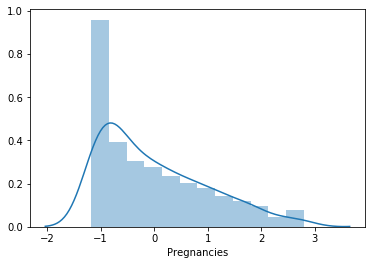

In [14]:
sns.distplot(numerical_variables["Pregnancies"])

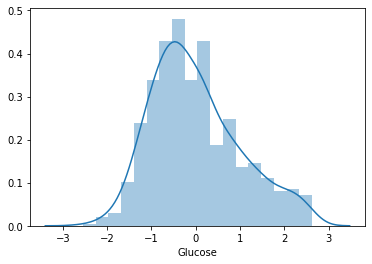

In [15]:
sns.distplot(numerical_variables["Glucose"])

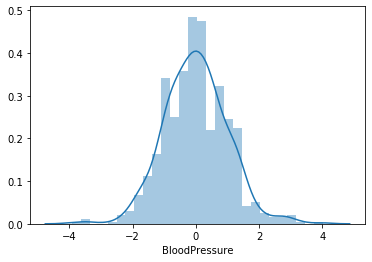

In [16]:
sns.distplot(numerical_variables["BloodPressure"])

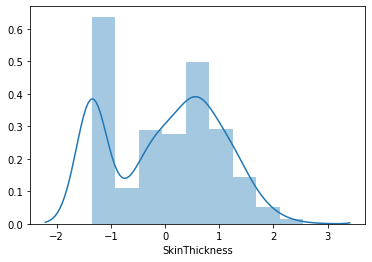

In [17]:
sns.distplot(numerical_variables["SkinThickness"])

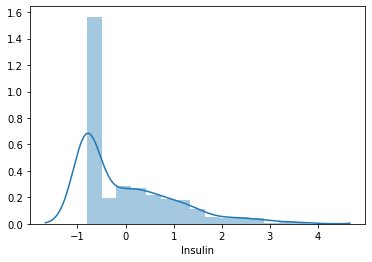

In [18]:
sns.distplot(numerical_variables["Insulin"])

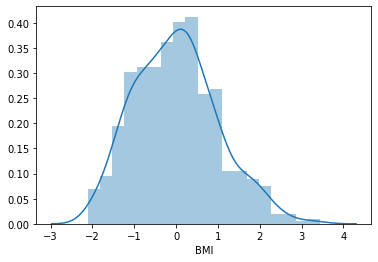

In [19]:
sns.distplot(numerical_variables["BMI"])

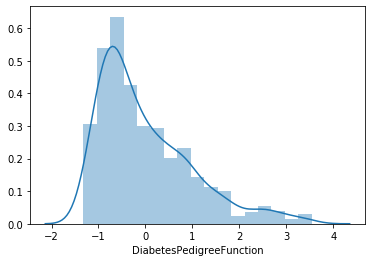

In [20]:
sns.distplot(numerical_variables["DiabetesPedigreeFunction"])

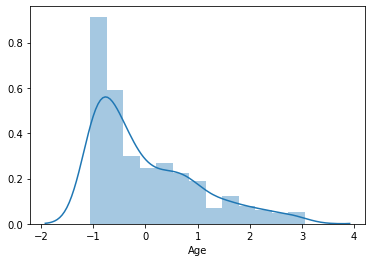

In [21]:
sns.distplot(numerical_variables["Age"])

In [22]:
def kolmogrov_smirnov_test(var):
    normal = []
    for column in var.columns:
        (KSstats, p_value) = kstest(var[column], "norm")
        alpha = 0.05
        if alpha <= p_value:
            normal.append(column)
        print(p_value)
    return normal
normal_variables = kolmogrov_smirnov_test(numerical_variables)
print(normal_variables)
Gaussian_variable = numerical_variables.loc[:, normal_variables]
numerical_variables.drop(columns=[normal_variables[0]], inplace=True)

8.866418098563021e-16
0.0002084779952876773
0.09560089806247873
1.0668656724386887e-21
1.0449812626303446e-41
0.4568466680586889
4.229009502490185e-09
4.504565083405106e-15
['BloodPressure', 'BMI']


In [23]:
def t_test (var, target):
    rejected = []
    for column in var.columns:
        grouped_data = [var[column][target.reset_index(drop=True) == category] for category in target.unique()]
        t_statistic, p_value = ttest_ind(*grouped_data)
        alpha = 0.1
        if p_value >= alpha:
            rejected.append(column)
        print(p_value)
    return rejected
rejected_variables = t_test(Gaussian_variable, diabetes_copy["Outcome"])
rejected_variables

1.4404635112148445e-06
1.394568246388992e-15


[]

In [24]:
def Mann_Whitney_U_test (var, target):
    rejected = []
    for column in var.columns:
        grouped_data = [var[column][target.reset_index(drop=True) == category] for category in target.unique()]
        U_statistic, p_value = mannwhitneyu(*grouped_data)
        alpha = 0.01
        if p_value >= alpha:
            rejected.append(column)
        print(p_value)
    return rejected
rejected_variables2 = Mann_Whitney_U_test(numerical_variables, diabetes_copy["Outcome"])
rejected_variables = rejected_variables+rejected_variables2
rejected_variables2

1.145346590442655e-08
7.715507032615492e-34
0.03198985784758219
0.10610132556223566
3.4796772064622975e-14
1.820304767347768e-07
5.121781434661496e-16


['SkinThickness', 'Insulin']

In [25]:
for column in rejected_variables:
    if column in diabetes.columns:
        diabetes.drop(column, axis=1, inplace=True)

diabetes.drop("DiabetesPedigreeFunction", axis=1, inplace=True)
diabetes

,Pregnancies,Glucose,BloodPressure,BMI,Age,Outcome
0,6,148,72,33.6,50,1
2,8,183,64,23.3,32,1
6,3,78,50,31.0,26,1
11,10,168,74,38.0,34,1
12,10,139,80,27.1,57,0
...,...,...,...,...,...,...
760,2,88,58,28.4,22,0
761,9,170,74,44.0,43,1
764,2,122,70,36.8,27,0
765,5,121,72,26.2,30,0


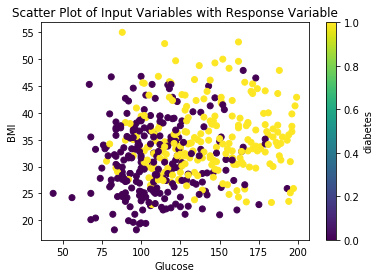

In [26]:
feature_1 = 'Glucose'
feature_2 = 'BMI'

plt.scatter(diabetes[feature_1], diabetes[feature_2], c=diabetes["Outcome"], cmap='viridis')  # cmap is the colormap
plt.colorbar(label='diabetes')  # Add colorbar to show the scale
plt.xlabel(feature_1)  # Label for the x-axis
plt.ylabel(feature_2)  # Label for the y-axis
plt.title('Scatter Plot of Input Variables with Response Variable')  # Title of the plot
plt.show()

In [27]:
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]

In [28]:
numerical_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(include=[object]).columns

In [29]:
numerical_transformation = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", scaler)
])

In [30]:
categorical_transformation = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [31]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformation, numerical_columns),
    ("cat", categorical_transformation, categorical_columns)
])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
number_of_rows = len(diabetes)
val = round(math.sqrt(number_of_rows))
if val%2 == 0:
    K = val
else:
    K = val-1

model_1 = KNeighborsClassifier()
model_2 = svm.SVC()
model_3 = LogisticRegression()
model_4 = DecisionTreeClassifier()
model_5 = GaussianNB()
model_6 = RandomForestClassifier()
model_7 = XGBClassifier()
model_8 = HistGradientBoostingClassifier()
model_9 = AdaBoostClassifier()
model_10 = ExtraTreesClassifier()

models1 = [model_1, model_4, model_8]
models2 = [model_6, model_5, model_7]
models3 = [model_3, model_10, model_9]




In [34]:
models = [model_1, model_2, model_10, model_4, model_5, model_6, model_7, model_8, model_9]

best_params_list = [] 
i = 0
for model in models:
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    i+=1
    if i == 1:
        param_grid = {
        'model__n_neighbors': [K-15, K-10, K-5, K, K+5, K+10, K+15],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__algorithm': ['ball_tree', "kd_tree", "brute", "auto"]
        }
    elif i ==2:
        param_grid = {'model__kernel': ["linear", "poly", 'rbf'],
                      'model__C': [0.001, 0.01, 0.1, 1.0, 10.0],
                      "model__gamma": ["auto"]
                 }
    elif i == 3:
        param_grid = { 'model__n_estimators': [10, 20, 30, 50, 60, 85, 100, 110, 120, 140, 150, 175, 200],
            'model__min_samples_leaf': [1, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                     }
    elif i == 4:
        param_grid = {'model__criterion': ["gini", "entropy"],
                  'model__max_leaf_nodes': [2, 5, 10, 20, 30, 50]
                 }
    elif i == 5:
        param_grid = {'model__var_smoothing': [10**-6, 10**-7,10**-8, 10**-9, 10**-10]
                     }     
    elif i == 6:
        param_grid = {'model__n_estimators': [50, 75, 100, 125, 150],
                  'model__criterion': ["gini", "entropy"]
                 }
    elif i == 7:
        param_grid = {'model__n_estimators': [50, 75, 100, 125, 150],
                  'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
                 }
    elif i == 8:
        param_grid = {'model__learning_rate': [0.05, 0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.9, 1],
            'model__min_samples_leaf': [1, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                }   
    else:
        param_grid = { 'model__learning_rate': [0.05, 0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.9, 1],
            'model__n_estimators': [10, 20, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
                 }
        

    # Create the grid search object
    bayes_search = BayesSearchCV(pipe, param_grid, scoring='f1', cv=5, n_jobs=4, n_iter=5)
    # Perform the grid search
    bayes_search.fit(X, y)

    # Get the best parameters and best score
    best_params = bayes_search.best_params_
    best_score = bayes_search.best_score_
    best_params_list.append(best_params)

    print(f"\033[1m\n**Model {i}**\n\033[0m")
    print(f"Best parameters:{best_params}")
    print(f"Best f1: {best_score}")


**Model 1**

Best parameters:OrderedDict([('model__algorithm', 'ball_tree'), ('model__metric', 'manhattan'), ('model__n_neighbors', 15), ('model__weights', 'distance')])
Best f1: 0.7479433432341234

**Model 2**

Best parameters:OrderedDict([('model__C', 10.0), ('model__gamma', 'auto'), ('model__kernel', 'linear')])
Best f1: 0.6878501428759922

**Model 3**

Best parameters:OrderedDict([('model__min_samples_leaf', 20), ('model__n_estimators', 50)])
Best f1: 0.7471481724388063

**Model 4**

Best parameters:OrderedDict([('model__criterion', 'gini'), ('model__max_leaf_nodes', 20)])
Best f1: 0.7513117408906883

**Model 5**

Best parameters:OrderedDict([('model__var_smoothing', 1e-07)])
Best f1: 0.7142038246177007

**Model 6**

Best parameters:OrderedDict([('model__criterion', 'gini'), ('model__n_estimators', 100)])
Best f1: 0.7493133444932545

**Model 7**

Best parameters:OrderedDict([('model__learning_rate', 0.1), ('model__n_estimators', 125)])
Best f1: 0.7503374362459309

**Model 8**

Bes

In [35]:
model_1 = KNeighborsClassifier(n_neighbors=best_params_list[0]["model__n_neighbors"], algorithm=best_params_list[0]["model__algorithm"], metric=best_params_list[0]["model__metric"], weights=best_params_list[0]["model__weights"])
model_2 = svm.SVC(C=best_params_list[1]["model__C"], gamma=best_params_list[1]["model__gamma"], kernel=best_params_list[1]["model__kernel"] )
model_10 = ExtraTreesClassifier(n_estimators=best_params_list[2]["model__n_estimators"], min_samples_leaf=best_params_list[2]["model__min_samples_leaf"])
model_4 = DecisionTreeClassifier(criterion=best_params_list[3]["model__criterion"], max_leaf_nodes=best_params_list[3]["model__max_leaf_nodes"])
model_5 = GaussianNB(var_smoothing=best_params_list[4]["model__var_smoothing"])
model_6 = RandomForestClassifier(n_estimators=best_params_list[5]["model__n_estimators"], criterion=best_params_list[5]["model__criterion"])
model_7 = XGBClassifier(n_estimators = best_params_list[6]["model__n_estimators"], learning_rate=best_params_list[6]["model__learning_rate"])
model_8 = HistGradientBoostingClassifier(min_samples_leaf= best_params_list[7]["model__min_samples_leaf"], learning_rate=best_params_list[7]["model__learning_rate"])
model_9 = AdaBoostClassifier(n_estimators= best_params_list[8]["model__n_estimators"], learning_rate=best_params_list[8]["model__learning_rate"])

In [36]:
model1 = StackingClassifier(classifiers=models1, meta_classifier=model_3)
model2 = StackingClassifier(classifiers=models2, meta_classifier=model_3)
model3 = StackingClassifier(classifiers=models3, meta_classifier=model_3)

model = VotingClassifier(estimators=[('S1', model1), 
                                   ('S2', model2), ('S3', model3)])
model = model_3
# Remove the `sample_weight` argument
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"The prediction for diabetes status:\n{y_pred}\n")
print(f"The true status of the diabetes:\n{y_test}\n")

The prediction for diabetes status:
[0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0
 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1]

The true status of the diabetes:
102    0
314    1
229    0
50     0
416    0
      ..
682    0
323    1
742    0
37     1
689    1
Name: Outcome, Length: 92, dtype: int64



In [37]:
cm = confusion_matrix(y_test, y_pred)
print(f"The confusion matrix is:\n {cm}\n")

The confusion matrix is:
 [[38  8]
 [20 26]]



In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy is: {accuracy:.4f}\n")

The accuracy is: 0.6957



In [39]:
f1_score = f1_score(y_test, y_pred)
print(f"The f1_score is: {f1_score:.4f}\n")

The f1_score is: 0.6500



In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"The AUC is: {auc:.4f}\n")

The AUC is: 0.6957



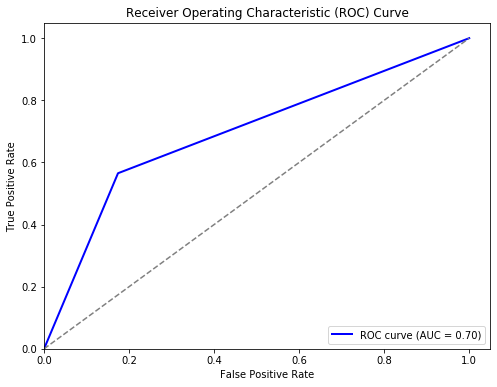

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [42]:
# import pickle
import pickle

# Make pickle file of our model
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(accuracy, open("accuracy.pkl", "wb"))